to do:
*   could try to set up paramfinder for lstm?
*   could try to implement multivaraible (multiple regression)? 






# Imports

In [1]:
import numpy as np                    # for data manipulation
import pandas as pd                   # for data manipulation
import itertools                      # for data manipulation
!pip install yfinance
import yfinance as yf                 # source of stock data
import statsmodels.api as sm          # for data analysis
import matplotlib.pyplot as plt       # for plotting data

# pre-processing      
from scipy.stats.stats import pearsonr                    # for Correlation calculation
from statsmodels.tsa.stattools import adfuller            # for data analysis
from statsmodels.tsa.seasonal import seasonal_decompose   # for seasonal trend analysis
from scipy.stats.morestats import Std_dev                 # std deviation for z normalization

# Holt winters method
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.api import Holt

# arima method
from statsmodels.tsa.arima.model import ARIMA

# rnn lstm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation

# silence alerts
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Pre-Processing

In [2]:
def getDF(stock='AAPL',  freq='1d', feature ='Close', timespan = '2y'):     # this func will extract the requested stock data from yahoo library
  data = yf.download(tickers=[stock], period=timespan)                      # getting stock data from yahoo finance (could also use interval feature inside this func but it doesnt seem to work with dataframes properly)
  df = data.resample(freq).mean()                                           # condense days into blocks of multiple days, uses mean value of days in block as new val
  df = df[feature].fillna(method='ffill')                                   # filling in blank spots with forward fill
  
  # min max rescaled copy
  dfs = (df-df.min())/(df.max()-df.min()) + 0.000001                          # last bit just to ensure no zero (would cause crashes)
  #reversedMinMax = (dfs - 0.000001) * (df.max() - df.min()) + df.min()       #  the reverse function for rescale, put here to just to remember it. is used elsewhere
  
  # z-normalized copy
  dfz = (df-df.mean()) / df.std()
  #reversedZnorm = dfz * dev + df.mean()                                       # reverse function for z normalization, here to remember it

  return df, dfs, dfz                                                          # sending back the regular data, the rescaled data, and z normalized data

In [3]:
stock = 'AAPL'      # stock of choice
freq = '7d'         # number of days to clump by and use average of. (downsampling)
feature = 'Close'   # main feature/value to be used
timespan = '5y'     # total time period to pull. "the last x months/years of data" (y=year, mo = month)
df, dfs, dfz = getDF(stock, freq, feature, timespan)
df

[*********************100%***********************]  1 of 1 completed


Date
2017-10-31     42.539500
2017-11-07     43.778500
2017-11-14     42.582500
2017-11-21     43.572500
2017-11-28     42.762501
                 ...    
2022-09-27    144.945996
2022-10-04    143.687997
2022-10-11    140.220001
2022-10-18    145.544000
2022-10-25    151.202002
Freq: 7D, Name: Close, Length: 261, dtype: float64

In [4]:
def analyzeData(df):
  dftest = adfuller(df, autolag = 'AIC')    # run adfuller test and output results
  output = f"adfuller Test results:\nADF = {dftest[0]}\nP-val = {dftest[1]}\nLag num = {dftest[2]}\n"
  output += f"num of observations = {dftest[3]}\nCritical Values:\n"
  for key, val in dftest[4].items():
      output+=f"\t{key}:{val}"
  print(output)
  # also plot data decompositions to see any patterns/trends
  result = seasonal_decompose(df)
  result.plot();    
  sm.graphics.tsa.plot_acf(df, lags=dftest[2]);   # plot auto correlation
  sm.graphics.tsa.plot_pacf(df, lags=dftest[2]);  # plot partial auto correlation

adfuller Test results:
ADF = -0.6811141849358349
P-val = 0.8515809325712469
Lag num = 1
num of observations = 259
Critical Values:
	1%:-3.4558530692911504	5%:-2.872764881778665	10%:-2.572751643088207


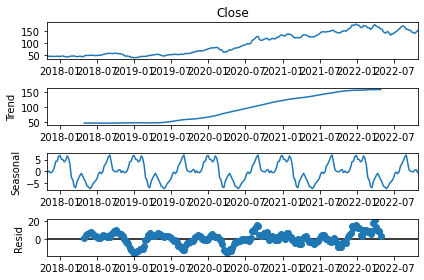

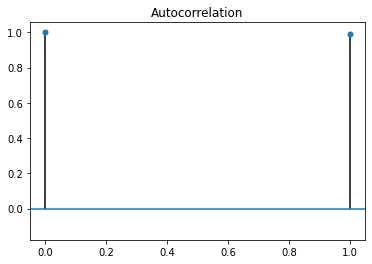

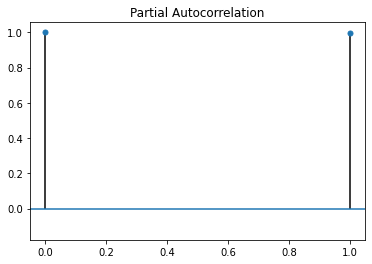

In [5]:
analyzeData(df)

In [6]:
def checkResults(pred, test): # formulas that will be used to evaluate accuracy of a model
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(test, pred)/ test))) * 100

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(test, pred)/ test))) * 100

  # Normalized Root Mean Squared Error (NRMSE)
  NRMSE = np.sqrt(np.mean(np.square(test - pred))) / (test.max() - test.min()) * 100

  # Correlation between Predicted Set and Test Set
  cor = (pearsonr(test, pred))[0] * 100

  return [MAPE, MDAPE, NRMSE, cor]

In [7]:
def kFoldSplit(inDF, folds):
  over = inDF.size % folds   # if not an even k-fold split, it will drop leading data to divide perfectly (the oldest points)
  sizePer = inDF.size//folds
  foldedData = []
  start = over
  for x in range(folds):
    foldedData.append(inDF[start:start+sizePer])
    start += sizePer

  return foldedData

# Holt Winters Method

## parameter selection using training portion

In [ ]:
# function to find best parameters with cross validation
def holtParamFinder(dff, possibleParams, trainSplit = 0.2, foldNum=3, numPreds=4):  # uses kfoldsplit function inside
  splitSpot = int(len(dff) * trainSplit)  # training cut of dff (0.2= use first 20% of data for param selection)
  trainDF = dff[:splitSpot] 
  results=[]
  foldDF = kFoldSplit(trainDF, foldNum)  # training data split into k folds ()
  for paramSet in possibleParams:
    # setting up each parameter, must be custom done for each model since they all have different parameters
    seasonalP = paramSet[0]  # seasonal period
    # had to use one-hot encoding for the more obscure parameters
    if paramSet[1]==2:      # trend
      trend='mul'
    elif paramSet[1]==1:
      trend='add'
    else:
      trend=None

    if paramSet[2]==2:      # seasonal trend
      seasonal='mul'
    elif paramSet[2]==1:
      seasonal='add'
    else:
      seasonal=None

    if paramSet[3]==1:    # damped setting
      damped=True
    else:
      damped=False
    # this param set now ready, next test with each fold of data
    scores = []
    for fold in foldDF:
      try: # in try catch as some params may cause crash, they wont be saved/used
        model = ExponentialSmoothing(fold, seasonal_periods=seasonalP, trend=trend, seasonal=seasonal, damped_trend=damped).fit() # could try rolling pred function version
        preds = model.forecast(numPreds)
        test = dff.loc[preds.index.min():preds.index.max()]          # for checking its accuracy only
        eval = checkResults(preds,test)                              # run evaluation calculations
        avgErr = (eval[0]+eval[1]+eval[2])/3                         # average of MAPE, MDAPE, and NRMSE
        scores.append((avgErr+(100-eval[3]))/2)                      # average err score of all 4 metrics (correlation had to be inverted so formula alitle strange)
        #scores.append(eval[0])                                      # could instead just use one of the scores instead like this- but why not use best of all 4 avged
      except:
        pass

    if len(scores)> 0:
      results.append([sum(scores)/len(scores), [seasonalP, trend, seasonal, damped]]) # avg all the results using this param set across each fold and save with the param set

  results.sort(key=lambda x: x[0])                                  # sorting by accuracy metric, lowest/best scores first
  return results

In [ ]:
#finding best parameters to use for this data based on training portion with cross validation parameter selection function
# holt param ranges using one-hot encoding for the non ints
holtParams=[range(2,14), range(1,3), range(1,3), range(0,2)]  #holt params = [(seasonalPeriod=number), (trend=none,add,mul), (seasonalTrend=none,add,mul), (dampedTrend=false, true)]
paramsH=list(itertools.product(*holtParams))                   # list of all parameters to try
print('num of possible param setups:', len(paramsH))

num of possible param setups: 96


In [ ]:
trainSplit = 0.5                                              # % of data to use for training data in the paramter search
folds = 3                                                     # number of folds to divide training data into
numPreds = 4                                                  # number of steps to predict with the model

bestHoltParams = holtParamFinder(df, paramsH, trainSplit, folds, numPreds)
for x in range(10):                                     # getting top 10 param setups, lowest score is best
    print(f'{x}.  score: {bestHoltParams[x][0]} = Seasonal Period: {bestHoltParams[x][1][0]}, Trend: {bestHoltParams[x][1][1]}, Seasonal Trend: {bestHoltParams[x][1][2]}, Damp Trend: {bestHoltParams[x][1][3]}\n')  

0.  score: 19.63184813254787 = Seasonal Period: 11, Trend: add, Seasonal Trend: add, Damp Trend: True

1.  score: 20.54762065276688 = Seasonal Period: 11, Trend: add, Seasonal Trend: add, Damp Trend: False

2.  score: 22.912151440810465 = Seasonal Period: 11, Trend: mul, Seasonal Trend: mul, Damp Trend: False

3.  score: 23.928505966053574 = Seasonal Period: 8, Trend: add, Seasonal Trend: add, Damp Trend: True

4.  score: 24.03260411297548 = Seasonal Period: 11, Trend: mul, Seasonal Trend: mul, Damp Trend: True

5.  score: 24.59123347925809 = Seasonal Period: 13, Trend: add, Seasonal Trend: add, Damp Trend: True

6.  score: 25.282208828272946 = Seasonal Period: 8, Trend: add, Seasonal Trend: mul, Damp Trend: False

7.  score: 25.575883345777118 = Seasonal Period: 8, Trend: mul, Seasonal Trend: mul, Damp Trend: True

8.  score: 26.12256635514377 = Seasonal Period: 8, Trend: add, Seasonal Trend: mul, Damp Trend: True

9.  score: 26.264317132047168 = Seasonal Period: 8, Trend: add, Season

## predicting on test portion, and getting future predictions

In [ ]:
def getHoltWinterRollingPreds(df, numPreds=1, trend=None, seasonal=None, seasonalP=None, damped=False, sliding=False, slideSize='90D', trace=False):   
# gets full data predictions by conglomerating tests as it slides across data
# this is necessary to evaluate the final prediction which does not have known data to check against. 
# this function will use the same model parameters to predict known data as if the model was in the past, and will repeat that many times as it moves through the dates.
# numPreds is how many points to predict at each step, also tied to freq (ex 2 preds on 30D freq means it will predict 60 days out, but 2 preds on 15d freq will predict 30days out)
  
  if str(df.index.freq) == '<Day>':  # freq of 1d turns into just <Day>, everything else becomes <x * Days>
    interval = 1
  else:
    interval = int((str(df.index.freq).split(' ')[0])[1:])    # interval of the data or the time between each point (weekly data would be 7 as it assumes daily is baseline)

  start = df.index.min()                                      # start at first day in set
  stop = start + pd.Timedelta(days=interval * numPreds)       # training from start -> stop
  if sliding == True:
      slide = int(slideSize[:-1])                             # size of each training window
      while (stop - start) < pd.Timedelta(days=slide):      
            stop = stop + pd.Timedelta(days=interval)         # if sliding training, the first training set needs to be atleast slide size
  
  end = stop + pd.Timedelta(days=interval * numPreds)         # predicting from stop -> end                                 
  finalDate = str(df.index.max() + pd.Timedelta(days=interval * numPreds))  # final date pre calced based on last day and number of steps to predict
  currentDate = stop                                          # while condition
  dates = []
  preds = [] 
  
  while currentDate < pd.to_datetime(finalDate):              # loop thru data making/collecting preds as it goes
      if trace == True:
              print(f'{str(start).split(" ")[0]} <---training---> {str(stop).split(" ")[0]} <---predicting---> {str(end).split(" ")[0]}')

      train = df.loc[start:stop]                              # making train set segment
      
      try:    #  certain parameters can cause first few predictions to crash when not enough data points yet, so put into try-catch
          model = ExponentialSmoothing(train, seasonal_periods=seasonalP, trend=trend, seasonal=seasonal, damped=damped).fit()  # create model fitted to this train set
          values = model.predict(stop + pd.Timedelta(days=interval), end) # get predictions for same range as validation/test set
          for x in values[:numPreds]:                         # conglomerate results
              preds.append(x)                                 # add pred to preds
          for y in values.index[:numPreds]:
              dates.append(y)                                 # get dates for each pred
      except:
          pass
      
      stop = stop + pd.Timedelta(days=interval * numPreds)    # for next training range
      end = stop + pd.Timedelta(days=interval * numPreds)     # for next predicting range
      currentDate = stop                                      # while condition

      if sliding == True:                                     # also for next training start
          while (stop - start) > pd.Timedelta(days=slide):    # if current training gap is wider than slide size
              start = start + pd.Timedelta(days=interval)     # make it the right size by shifting start closer to stop

  result = pd.DataFrame(preds, dates)                         # create df of fused prediction results
  result.index.name = 'date'                                  # setting propper label
  while result.index[-1] > pd.to_datetime(finalDate)+pd.Timedelta(days=interval-1):         # sometimes final prediction goes father than it should be due to date rounding/grouping (downsampling and dateindex looping)
    result.drop(index=pd.to_datetime(result.index[-1]), inplace=True)   # remove last pred if more than expected
  return result

In [ ]:
# predict all data while moving along the date axis using only whats available so far as the training/fit (this will also predict into future but the known predictions can be evaluated to gauge accuracy of the future ones)
# inputdata is cut to not include the portion used for training cross validation param selection
inputData = df[int(len(df) * (1-trainSplit)):]      # be sure to check if using df, dfs, or dfz (df is regular data, dfs is minmax rescaled, dfz is z normalized.)
numPreds=4          # numpreds is how many datapoints to predict, the final date is based on freq of data (7d freq with 4 preds is 28days of predictions clumped in 4 points) 
                    # numPreds should be consistent as paramfinder searches for best param with given numPreds value

#---holt params, using results from paramfinder---------
p=bestHoltParams[0]  # parameters from paramfinder, can change index to go from top choice (0) to other choices
seasonalP=p[1][0]      # size of seasonal cycle in points
trend=p[1][1]          # regular trend (none, add, mul)
seasonal=p[1][2]       # seasonal trend (none, add, mul)
damped=p[1][3]         # dampening(true/false) is to smooth out the input values and prevent it from getting confused by noisy data

#----rolling function params, not necessary but may help to use them---------------
sliding=False       # sliding is to train with a specific sized window instead of all previous data in the rolling loop
slideSize='None'    # slide size dictates size of the window if sliding is true (360d = 360 days)
trace=False         # set to true to get print statements of what its doing while it does it

predictions = getHoltWinterRollingPreds(inputData, numPreds, trend, seasonal, seasonalP, damped, sliding, slideSize, trace)

if inputData.equals(dfs[int(len(df) * (1-trainSplit)):]):  # check to see if results need to be reversed, and if so, which formula
  predictions = (predictions - 0.000001) * (df.max() - df.min()) + df.min() # for reversing min max rescaled predictions (for dfs)
elif inputData.equals(dfz[int(len(df) * (1-trainSplit)):]):
  predictions = predictions * df.std() + df.mean()  # for reversing z-normalized predictions (for dfz)

predictions         # showing predictions

2020-04-21 <---training---> 2020-05-19 <---predicting---> 2020-06-16
2020-04-21 <---training---> 2020-06-16 <---predicting---> 2020-07-14
2020-04-21 <---training---> 2020-07-14 <---predicting---> 2020-08-11
2020-04-21 <---training---> 2020-08-11 <---predicting---> 2020-09-08
2020-04-21 <---training---> 2020-09-08 <---predicting---> 2020-10-06
2020-04-21 <---training---> 2020-10-06 <---predicting---> 2020-11-03
2020-04-21 <---training---> 2020-11-03 <---predicting---> 2020-12-01
2020-04-21 <---training---> 2020-12-01 <---predicting---> 2020-12-29
2020-04-21 <---training---> 2020-12-29 <---predicting---> 2021-01-26
2020-04-21 <---training---> 2021-01-26 <---predicting---> 2021-02-23
2020-04-21 <---training---> 2021-02-23 <---predicting---> 2021-03-23
2020-04-21 <---training---> 2021-03-23 <---predicting---> 2021-04-20
2020-04-21 <---training---> 2021-04-20 <---predicting---> 2021-05-18
2020-04-21 <---training---> 2021-05-18 <---predicting---> 2021-06-15
2020-04-21 <---training---> 2021-0

,0
date,
2020-10-13,119.729838
2020-10-20,126.053678
2020-10-27,126.892289
2020-11-03,130.954098
2020-11-10,120.074417
...,...
2022-10-18,141.583746
2022-10-25,141.028245
2022-11-01,141.317502


Holt-Winters Model Settings:
Steps = 4, Trend Setting = add, Seasonal Setting = add,
Seasonal Period = 11, Dampening = True, sliding = False, slide size = None

Mean Absolute Percentage Error on Validation Set (MAPE): 5.02 %
Median Absolute Percentage Error  on Validation Set (MDAPE): 3.68 %
Normalized Root Mean Squared Error on Validation Set (NRMSE): 14.45 %

Correlation between Predicted Values and Validation Set: 85.56 %


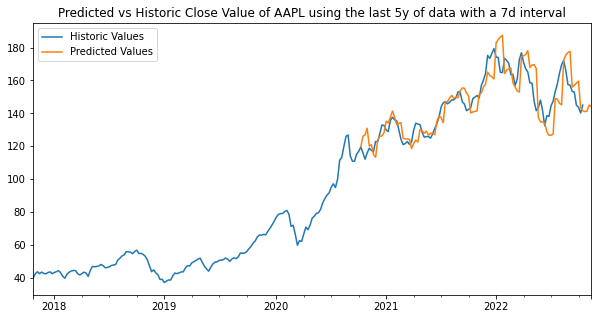

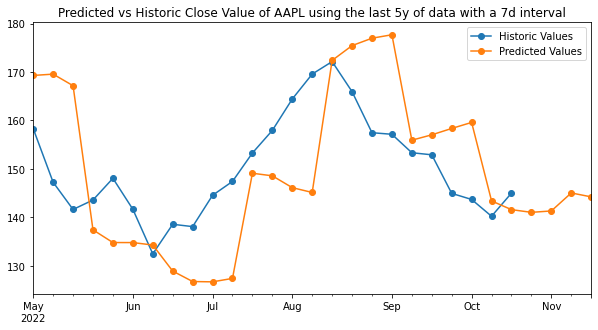

In [ ]:
# making two graphs of same output, second one is just zoomed on the end
# first setting up data and lables
gName = f'Predicted vs Historic {feature} Value of {stock} using the last {timespan} of data with a {freq} interval' 
dfn = pd.concat([df, predictions], axis=1)
dfn.columns.values[0] = f'Historic Values'
dfn.columns.values[1] = f'Predicted Values'

# graphing all of it
dfn['Historic Values'].plot(legend=True, figsize=(10, 5), title=gName)
dfn['Predicted Values'].dropna().plot(legend=True) # droping any nans that were created in predicted so graph is fully connected (rarely occurs with holt winter due to certain seasonal period settings)

# graphing same data from above but zoomed in on the future preds
startdate = '2022/5/1'                            # start graphing from this date
dfn.loc[startdate:].plot(legend=True, figsize=(10, 5), marker="o", title=gName)

# print out metrics and settings
print(f'Holt-Winters Model Settings:\nSteps = {numPreds}, Trend Setting = {trend}, Seasonal Setting = {seasonal},\nSeasonal Period = {seasonalP}, Dampening = {damped}, sliding = {sliding}, slide size = {slideSize}\n')
dfc = dfn.dropna()                              # remove the data that wasnt predicted on or isnt known (they created NaNs when fused to dfn)
pred = dfc['Predicted Values']
test = dfc['Historic Values']

eval = checkResults(pred, test)                        # run evaluation calculations
print(f'Mean Absolute Percentage Error on Validation Set (MAPE): {np.round(eval[0], 2)} %')      # want this low
print(f'Median Absolute Percentage Error  on Validation Set (MDAPE): {np.round(eval[1], 2)} %') # want this low
print(f'Normalized Root Mean Squared Error on Validation Set (NRMSE): {np.round(eval[2], 2)} %') # want this low
print(f'\nCorrelation between Predicted Values and Validation Set: {np.round(eval[3], 2)} %')      # want this high

# ARIMA Method

## parameter selection using training portion

In [ ]:
# function to find best parameters with cross validation
def arimaParamFinder(dff, possibleParams, trainSplit = 0.2, foldNum=3, numPreds=4):  # uses kfoldsplit function inside
  splitSpot = int(len(dff) * trainSplit)  # if using a larger period size, will need to use more of the data for holt to be able to run
  trainDF = dff[:splitSpot]  # training cut of dff (0.2= use first 20% of data)
  results=[]
  foldDF = kFoldSplit(trainDF, foldNum)
  for paramSet in possibleParams:
    # setting up each parameter, must be custom done for each model since they all have different parameters
    order = paramSet[:3]
    seasonalOrder = paramSet[3:]
    
    scores = []
    for fold in foldDF: # this param set now ready, next test it with each fold of data
      try: # in try catch as some params may cause crash, they wont be saved/used
        model = ARIMA(trainDF, order=order, seasonal_order=seasonalOrder, enforce_stationarity=False).fit() # could try rolling pred function version
        preds = model.forecast(numPreds)      
        test = dff.loc[preds.index.min():preds.index.max()]          # for checking its accuracy only
        eval = checkResults(preds,test)                              # run evaluation calculations
        avgErr = (eval[0]+eval[1]+eval[2])/3                         # average of MAPE, MDAPE, and NRMSE
        scores.append((avgErr+(100-eval[3]))/2)                      # average err score of all 4 metrics (correlation had to be inverted so formula alitle strange)
      except:
        pass

    if len(scores)> 0:
      results.append([sum(scores)/len(scores), [order, seasonalOrder]])
  
  results.sort(key=lambda x: x[0])                                  # sorting by accuracy metric, lowest/best scores first
  return results

In [ ]:
#finding best parameters to use for this data based on training portion with cross validation parameter selection function
arimaParams=[range(1,3), range(0,2), range(0,2), range(0, 2), range(0,2), range(0,2), range(1,3)]  #arima params 2 sets, split between order(first 3) and seasonal order (last 4)
paramsA=list(itertools.product(*arimaParams))                   # list of all parameters to try
print('num of possible param setups:', len(paramsA))

num of possible param setups: 128


In [ ]:
trainSplit = 0.5                                              # % of data to use for training data in the paramter search
folds = 3                                                     # number of folds to divide training data into
numPreds = 4                                                  # number of steps to predict with the model

bestArimaParams = arimaParamFinder(df, paramsA, trainSplit, folds, numPreds)
for x in range(10):                                     # getting top 10 param setups, lowest score is best
    print(f'{x}.  score: {bestArimaParams[x][0]}, order: {bestArimaParams[x][1][0]}, seasonal Order {bestArimaParams[x][1][1]}\n')  

0.  score: 5.749938110895202, order: (1, 0, 0), seasonal Order (1, 1, 0, 2)

1.  score: 6.841369217676486, order: (2, 1, 1), seasonal Order (0, 0, 1, 2)

2.  score: 6.9221531420640545, order: (1, 1, 1), seasonal Order (0, 0, 1, 2)

3.  score: 7.007037342637486, order: (1, 1, 1), seasonal Order (1, 0, 0, 2)

4.  score: 7.1309751535492865, order: (2, 1, 0), seasonal Order (0, 0, 1, 2)

5.  score: 7.184923946589755, order: (2, 0, 1), seasonal Order (0, 1, 1, 2)

6.  score: 7.229875058640379, order: (2, 1, 0), seasonal Order (0, 1, 1, 2)

7.  score: 7.274619652421308, order: (2, 1, 1), seasonal Order (0, 0, 0, 2)

8.  score: 7.403292531490968, order: (1, 1, 1), seasonal Order (0, 1, 1, 2)

9.  score: 7.4231997326433286, order: (1, 1, 1), seasonal Order (0, 0, 0, 2)



## predicting on test portion, and getting future predictions

In [ ]:
def getArimaRollingPreds(df, order=None, seasonal_order=None, numPreds=1, sliding=False, slideSize='90D', trace=False):
# gets full data (S)ARIMA predictions by conglomerating tests as it slides across data
# this is necessary to evaluate the final prediction which does not have known data to check against. so instead i can try to predict all the known data prior as i pass through and test that to give an idea of the future predictions accuracy
# numPreds is how many points to predict at each step, also tied to freq (ex 2 preds on 30D freq means it will predict 60 days out, but 2 preds on 15d freq will predict 30days out)
  days = int((str(df.index.freq).split(' ')[0])[1:])  # getting interval/frequency of the data in days
  if days == 0:   # 1d freq results in d = 0 for some reason
      days = 1
    
  start = df.index.min()    # start at begining of given data set's date
  stop = start + pd.Timedelta(days=days * numPreds)  # training from start ->  stop + (frequency * numpreds)
  if sliding == True:
      slide = int(slideSize[:-1])
      stop = start + pd.Timedelta(days=slide)    # if sliding training, the first training set needs to be equal to slide size
  end = stop + pd.Timedelta(days=days * numPreds)   # predicting from stop -> end = stop + (frequency * numpreds)
                                       
  finalDate = str(df.index.max() + pd.Timedelta(days=days * numPreds))  # final date pre calced based on last day and number of steps to predict

  currentDate = stop      # while condition
  dates = []
  preds = [] 
  
  while currentDate <= pd.to_datetime(finalDate):     # loop thru data making preds as it goes
      if trace == True:
          print(f'{str(start).split(" ")[0]} <---training---> {str(stop).split(" ")[0]} <---predicting---> {str(end).split(" ")[0]}')
      train = df.loc[start:stop]      # making train/test set
      
      try:    #  certain parameters can cause first few predictions to crash when not enough data points yet, so put into try-catch
        model = ARIMA(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)   
        model = model.fit()                               # training on train set to try and predict test set
        values = model.predict(start=stop, end=end, type='levels') # prediction for same range as test set to compare
        for x in values[:numPreds]:   # conglomerate results
            preds.append(x)    # add pred to preds
        for y in values.index[:numPreds]:
            dates.append(y)   # get dates for each pred
      except:
        pass

      stop = stop + pd.Timedelta(days=days * numPreds)  # training from start -> stop + (frequency * numpreds)
      end = stop + pd.Timedelta(days=days * numPreds)   # predicting from stop -> end = stop + (frequency * numpreds)
      currentDate = stop

      if sliding == True:
          if (stop - start) > pd.Timedelta(days=slide):      # if current training gap is wider than slide size
              start = stop - pd.Timedelta(days=slide)        # make it the right size by shifting start closer to stop


  result = pd.DataFrame(preds, dates)     # create df of fused prediction results
  result.index.name = 'date'
  while result.index[-1] > pd.to_datetime(finalDate)+pd.Timedelta(days=days-1):    # sometimes final prediction ends up being father than it should be due to date downsampling and dateindex looping and numsteps
      result.drop(index=pd.to_datetime(result.index[-1]), inplace=True)   # remove last pred if more than expected
  return result

In [ ]:
# predict all data while moving along the date axis using only whats available so far as the training/fit (this will also predict into future but the known predictions can be evaluated to gauge accuracy of the future ones)
# inputdata is cut to not include the portion used for training cross validation param selection
inputData = df[int(len(df) * (1-trainSplit)):]      # be sure to check if using df, dfs, or dfz (df is regular data, dfs is minmax rescaled, dfz is z normalized.)
numPreds=4          # numpreds is how many datapoints to predict, the final date is based on freq of data (7d freq with 4 preds is 28days of predictions clumped in 4 points) 
                    # numPreds should be consistent as paramfinder searches for best param with given numPreds value

#---arima params, using results from paramfinder---------
p=bestArimaParams[0]  # parameters from paramfinder, can change array index to go from top choice (0) to other choices
order = p[1][0]              # The (p,d,q) is number of AR parameters, differences, and MA parameters to use.
seasonalOrder = p[1][1]     # (P, D, Q, s) for seasonal components. s is seasonal cycle size in intervals

#----rolling function params, not necessary but may help to use them---------------
sliding=False       # sliding is to train with a specific sized window instead of all previous data in the rolling loop
slideSize='None'    # slide size dictates size of the window if sliding is true (360d = 360 days)
trace=False         # set this to true to get print statements of what its doing while it does it

predictions = getArimaRollingPreds(inputData, order, seasonalOrder, numPreds, sliding, slideSize, trace)

if inputData.equals(dfs[int(len(df) * (1-trainSplit)):]):  # check to see if results need to be reversed, and if so, which formula
  predictions = (predictions - 0.000001) * (df.max() - df.min()) + df.min() # for reversing min max rescaled predictions (for dfs)
elif inputData.equals(dfz[int(len(df) * (1-trainSplit)):]):
  predictions = predictions * df.std() + df.mean()  # for reversing z-normalized predictions (for dfz)

predictions         # showing predictions

,0
date,
2020-05-19,75.295917
2020-05-26,79.799693
2020-06-02,80.448931
2020-06-09,80.717818
2020-06-16,88.772337
...,...
2022-10-18,140.782500
2022-10-25,136.604677
2022-11-01,142.772588


ARIMA Model Settings:
Steps = 4, order = (1, 0, 0), Seasonal order = (1, 1, 0, 2), sliding = False, slide size = None

Mean Absolute Percentage Error on Validation Set (MAPE): 4.2 %
Median Absolute Percentage Error  on Validation Set (MDAPE): 3.36 %
Normalized Root Mean Squared Error on Validation Set (NRMSE): 7.44 %

Correlation between Predicted Values and Validation Set: 95.05 %


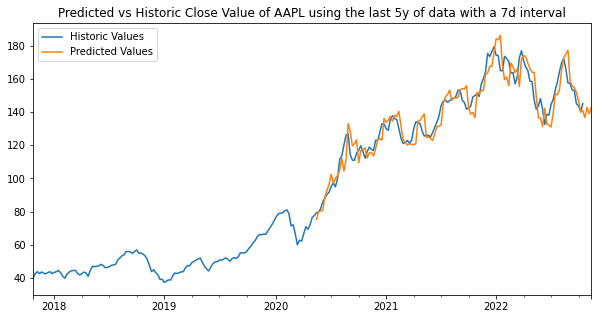

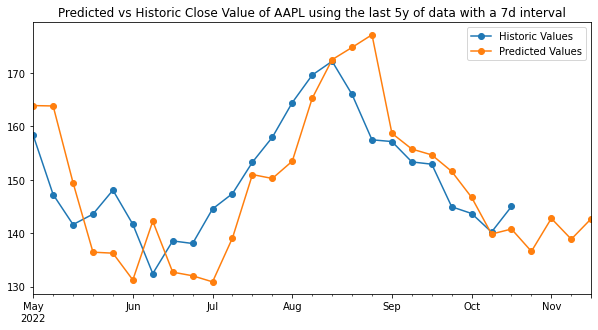

In [ ]:
# making two graphs of same output, second one is just zoomed on the end
# first setting up data and lables
gName = f'Predicted vs Historic {feature} Value of {stock} using the last {timespan} of data with a {freq} interval' 
dfn = pd.concat([df, predictions], axis=1)
dfn.columns.values[0] = f'Historic Values'
dfn.columns.values[1] = f'Predicted Values'

# graphing all of it
dfn['Historic Values'].plot(legend=True, figsize=(10, 5), title=gName)
dfn['Predicted Values'].dropna().plot(legend=True) # droping any nans that were created in predicted so graph is fully connected (rarely occurs with holt winter due to certain seasonal period settings)

# graphing same data from above but zoomed in on the future preds
startdate = '2022/5/1'                            # start graphing from this date
dfn.loc[startdate:].plot(legend=True, figsize=(10, 5), marker="o", title=gName)

# print out metrics and settings
print(f'ARIMA Model Settings:\nSteps = {numPreds}, order = {order}, Seasonal order = {seasonalOrder}, sliding = {sliding}, slide size = {slideSize}\n')
dfc = dfn.dropna()                              # removing all the data that wasnt predicted on or isnt known (they created NaNs when fused to dfn)
pred = dfc['Predicted Values']
test = dfc['Historic Values']

eval = checkResults(pred, test)                        # run evaluation calculations
print(f'Mean Absolute Percentage Error on Validation Set (MAPE): {np.round(eval[0], 2)} %')      # want this low
print(f'Median Absolute Percentage Error  on Validation Set (MDAPE): {np.round(eval[1], 2)} %') # want this low
print(f'Normalized Root Mean Squared Error on Validation Set (NRMSE): {np.round(eval[2], 2)} %') # want this low
print(f'\nCorrelation between Predicted Values and Validation Set: {np.round(eval[3], 2)} %')      # want this high

# LSTM method






In [297]:
# Convert the data to numpy values
dataScaled = np.array(dfs)   # must use rescaled data for lstm
dataScaled = np.reshape(dataScaled, (dfs.shape[0], -1))  # df.shape[0] is num rows
print(f'data shape: {dataScaled.shape}')

data shape: (261, 1)


In [298]:
# data made into a series of windows for the lstm
# trains on x, then tries to predict y, then adjusts itself based on how wrong it was for fitting on each window
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, data.shape[0]): # making many windows of the given test data and its corresponding validation data
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, 0]) #contains the prediction values for validation
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [299]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequenceLen = 7   
trainPercent = 0.5     

# Split the training data into x train and y train data sets
# As a first step, we get the number of rows to train the model with some % of the data 
trainLen = int(dataScaled.shape[0] * trainPercent)+1  # round up to int

# Create the training and test data
trainData = dataScaled[0:trainLen, :]
testData = dataScaled[trainLen - sequenceLen:, :]

# Generate training data and test data
xTrain, yTrain = partition_dataset(sequenceLen, trainData)  
xTest, yTest = partition_dataset(sequenceLen, testData)

# Print the shapes: the result should be (rows, training_sequence, (prediction value, features) )
print(f'x train shape: {xTrain.shape} y train shape {yTrain.shape}')
print(f'x test shape: {xTest.shape} y test shape {yTest.shape}')

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
if xTest[1][sequenceLen-1][0] == yTest[0]:
    print('sets are properly lined up')
else:
    print('there is a problem, sets are not lined up')

x train shape: (124, 7, 1) y train shape (124,)
x test shape: (130, 7, 1) y test shape (130,)
sets are properly lined up


In [300]:
# Configure the neural network model
epochs = 6
batchSize = 3

# Model
neurons = xTrain.shape[1] * xTrain.shape[2]
model = Sequential()

model.add(LSTM(neurons, return_sequences=False, input_shape=(xTrain.shape[1], 1)))   # if not final lstm layer, return sequence should be True
#model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(sequenceLen))
model.add(Dense(1))  
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(xTrain, yTrain, batch_size=batchSize, epochs=epochs)

Epoch 1/6
42/42 [==============================] - 2s 4ms/step - loss: 0.0022
Epoch 2/6
42/42 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 3/6
42/42 [==============================] - 0s 5ms/step - loss: 7.3874e-04
Epoch 4/6
42/42 [==============================] - 0s 5ms/step - loss: 6.7493e-04
Epoch 5/6
42/42 [==============================] - 0s 4ms/step - loss: 7.0453e-04
Epoch 6/6
42/42 [==============================] - 0s 4ms/step - loss: 7.0295e-04


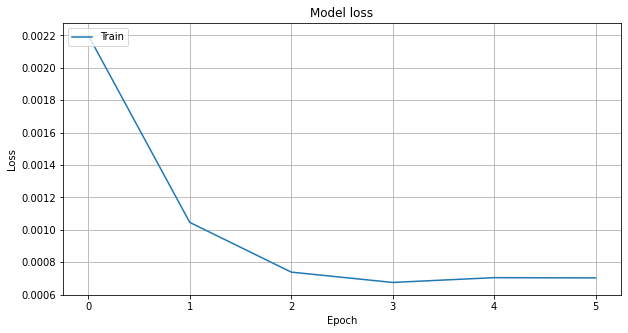

In [301]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

In [302]:
# predicting on validation set for accuracy checks
# Reshape the data, so that we get an array with multiple test datasets
xTest = np.array(xTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))
     
# Get the predicted values for validation section
preds = model.predict(xTest)

dates = df.index[len(xTrain)+sequenceLen:] 
preds = pd.DataFrame(preds, dates)
validationPreds = (preds - 0.000001) * (df.max() - df.min()) + df.min() # for reversing min max rescaled predictions (for dfs)
validationPreds

5/5 [==============================] - 0s 3ms/step


,0
Date,
2020-05-05,68.465828
2020-05-12,70.961792
2020-05-19,73.046707
2020-05-26,75.165863
2020-06-02,76.691162
...,...
2022-09-27,147.160980
2022-10-04,143.742767
2022-10-11,141.068008


In [303]:
# doing a type of rolling forecast to predict into unknown data (future points)
numSteps = 4

# Making a Multi-Step Prediction by looping 1 output continously back into itself, without re-training or re-fitting
# Create copy of the initial input data to fill as it goes
interval = int((str(df.index.freq).split(' ')[0])[1:])
newDf = dfs.copy()
# now rolling forecast
for i in range(0, numSteps):
    # Select the last sequence from the new dataframe as input
    last_values = newDf.values[-sequenceLen:]

    # turn input data to np array and bring it into shape
    X_input = np.array(last_values).reshape([1, neurons, 1])
    
    # predicting the next point in given sequence of data (the next future pred)
    pred = float(model.predict_step(X_input))  # reading as float to convert tensor output to its single number prediction

    # Add the prediction to the next input 
    date = newDf.iloc[[-1]].index.values + pd.Timedelta(days=interval)
    temp = pd.DataFrame(data=[pred], index=date)  # temp df holding new pred and new date
    newDf = pd.concat([newDf, temp])  # add temp to new df

futurePreds = newDf[-numSteps:]
futurePreds = (futurePreds - 0.000001) * (df.max() - df.min()) + df.min()
futurePreds

,0
2022-11-01,139.143590
2022-11-08,136.564859
2022-11-15,134.457669
2022-11-22,132.685181


LSTM Model Settings:
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 7)                 252       
                                                                 
 dense_54 (Dense)            (None, 7)                 56        
                                                                 
 dense_55 (Dense)            (None, 1)                 8         
                                                                 
Total params: 316
Trainable params: 316
Non-trainable params: 0
_________________________________________________________________
Steps = 4, Sequence Length = 7
Epochs = 6, Batch Size = 3


Mean Absolute Percentage Error on Validation Set (MAPE): 6.52 %
Median Absolute Percentage Error  on Validation Set (MDAPE): 6.62 %
Normalized Root Mean Squared Error on Validation Set (NRMSE): 10.78 %

Correlation between Predicted Value

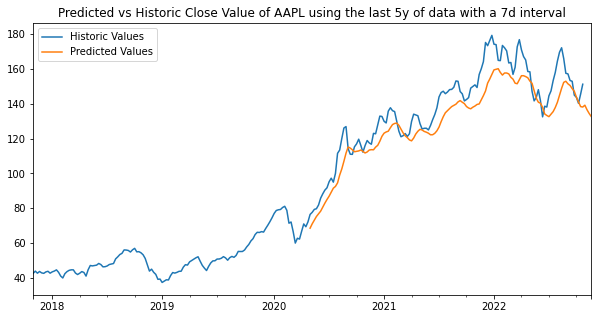

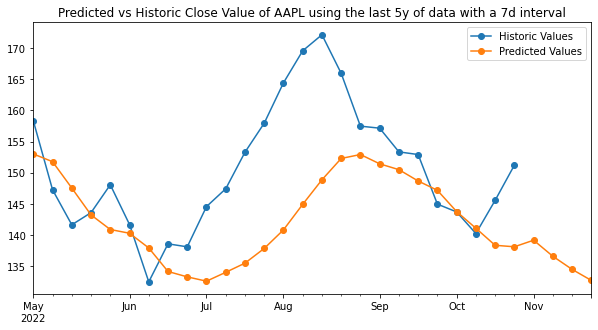

In [306]:
# making two graphs of same output, second one is just zoomed on the end
# first setting up data and lables
preds = pd.concat([validationPreds, futurePreds])  # join future preds with validation preds for graphing, future ones will be dropped for calcs tho as they have no baseline
gName = f'Predicted vs Historic {feature} Value of {stock} using the last {timespan} of data with a {freq} interval'
dfn = pd.concat([df, preds], axis=1)
dfn.columns.values[0] = 'Historic Values'
dfn.columns.values[1] = 'Predicted Values'

# graphing all of it
dfn['Historic Values'].plot(legend=True, figsize=(10, 5), title=gName)
dfn['Predicted Values'].dropna().plot(legend=True) # droping any nans that were created in predicted so graph is fully connected (rarely occurs with holt winter due to certain seasonal period settings)

# graphing same data from above but zoomed in on the future preds
startdate = '2022/5/1'                            # start graphing from this date
dfn.loc[startdate:].plot(legend=True, figsize=(10, 5), marker="o", title=gName)

# print out metrics and settings
print('LSTM Model Settings:')
model.summary()
print(f"Steps = {numSteps}, Sequence Length = {sequenceLen}\nEpochs = {epochs}, Batch Size = {batchSize}\n\n")   

dfc = dfn.dropna()                              # removing all the data that wasnt predicted on or isnt known (they created NaNs when fused to dfn)
pred = dfc['Predicted Values']
test = dfc['Historic Values']

eval = checkResults(pred, test)                        # run evaluation calculations
print(f'Mean Absolute Percentage Error on Validation Set (MAPE): {np.round(eval[0], 2)} %')      # want this low
print(f'Median Absolute Percentage Error  on Validation Set (MDAPE): {np.round(eval[1], 2)} %') # want this low
print(f'Normalized Root Mean Squared Error on Validation Set (NRMSE): {np.round(eval[2], 2)} %') # want this low
print(f'\nCorrelation between Predicted Values and Validation Set: {np.round(eval[3], 2)} %')      # want this high